In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from collections import Counter
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Reshape
from sklearn.model_selection import StratifiedKFold , cross_val_score
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Load the Epileptic Seizure Recognition dataset
df = pd.read_csv("Epileptic Seizure Recognition.csv")
df.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [3]:
nan_mask = df.isnull()
print(nan_mask)

       Unnamed     X1     X2     X3     X4     X5     X6     X7     X8     X9  \
0        False  False  False  False  False  False  False  False  False  False   
1        False  False  False  False  False  False  False  False  False  False   
2        False  False  False  False  False  False  False  False  False  False   
3        False  False  False  False  False  False  False  False  False  False   
4        False  False  False  False  False  False  False  False  False  False   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
11495    False  False  False  False  False  False  False  False  False  False   
11496    False  False  False  False  False  False  False  False  False  False   
11497    False  False  False  False  False  False  False  False  False  False   
11498    False  False  False  False  False  False  False  False  False  False   
11499    False  False  False  False  False  False  False  False  False  False   

       ...   X170   X171   

In [4]:
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)
print("\nClass Distribution:")
print(df['y'].value_counts())

Dataset Shape: (11500, 180)

Data Types:
Unnamed    object
X1          int64
X2          int64
X3          int64
X4          int64
            ...  
X175        int64
X176        int64
X177        int64
X178        int64
y           int64
Length: 180, dtype: object

Class Distribution:
y
4    2300
1    2300
5    2300
2    2300
3    2300
Name: count, dtype: int64


In [5]:
# Drop unnamed column
df.drop(df.columns[0], axis=1, inplace=True)

In [6]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


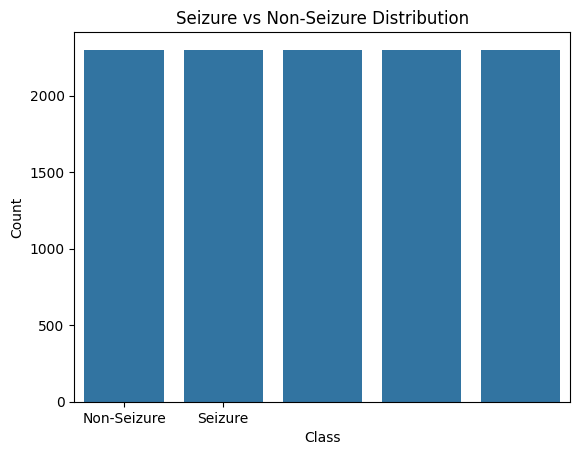

In [7]:
sns.countplot(x='y', data=df)
plt.title("Seizure vs Non-Seizure Distribution")
plt.xticks([0, 1], ["Non-Seizure", "Seizure"])
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [8]:
# Features and labels
X = df.drop(columns=['y']).values
y = df['y'].values - 1  # Adjust to 0-based indexing for multiclass
# Split
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_val = scaler.transform(x_val)
X_test = scaler.transform(x_test)

In [9]:
# <----------------Train XGBoost--------------->
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb_val = xgb.predict(X_val)
y_pred_xgb_test = xgb.predict(X_test)
# Evaluation
acc_xgb_val = accuracy_score(y_val, y_pred_xgb_val)
print(f"XGBoost validation Accuracy: {acc_xgb_val:.4f}")
acc_xgb_test = accuracy_score(y_test, y_pred_xgb_test)
print(f"XGBoost test Accuracy: {acc_xgb_test:.4f}")
print("\nConfusion Matrix for validation:")
print(confusion_matrix(y_val, y_pred_xgb_val))
print("\nClassification Report for validation:")
print(classification_report(y_val, y_pred_xgb_val))
print("\nConfusion Matrix for test:")
print(confusion_matrix(y_test, y_pred_xgb_test))
print("\nClassification Report for test:")
print(classification_report(y_test, y_pred_xgb_test))

XGBoost validation Accuracy: 0.6648
XGBoost test Accuracy: 0.6743

Confusion Matrix for validation:
[[423  11  12  14   0]
 [ 11 245 167   6  31]
 [  8 144 249  15  44]
 [  0  13  17 309 121]
 [  0  40  53  64 303]]

Classification Report for validation:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       460
           1       0.54      0.53      0.54       460
           2       0.50      0.54      0.52       460
           3       0.76      0.67      0.71       460
           4       0.61      0.66      0.63       460

    accuracy                           0.66      2300
   macro avg       0.67      0.66      0.67      2300
weighted avg       0.67      0.66      0.67      2300


Confusion Matrix for test:
[[430  14  10   6   0]
 [ 19 240 154  12  35]
 [  7 146 251  16  40]
 [  0   8  10 315 127]
 [  0  44  50  51 315]]

Classification Report for test:
              precision    recall  f1-score   support

           0       0.94 

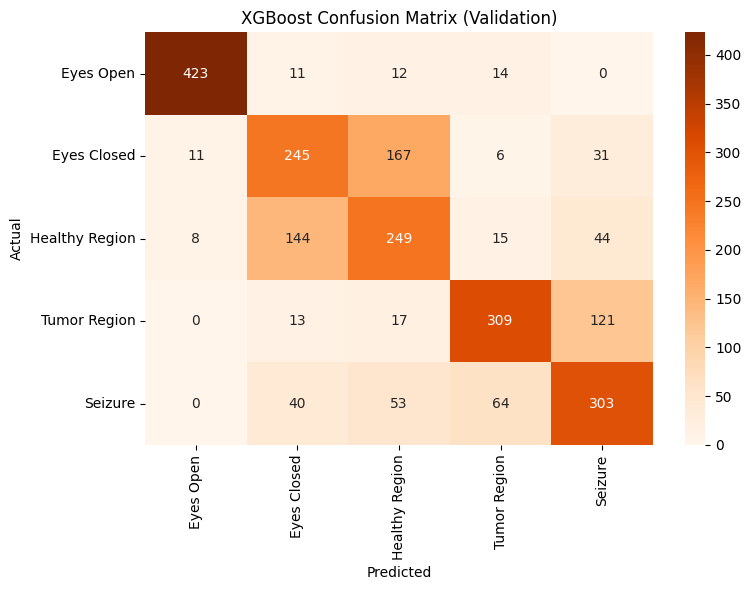

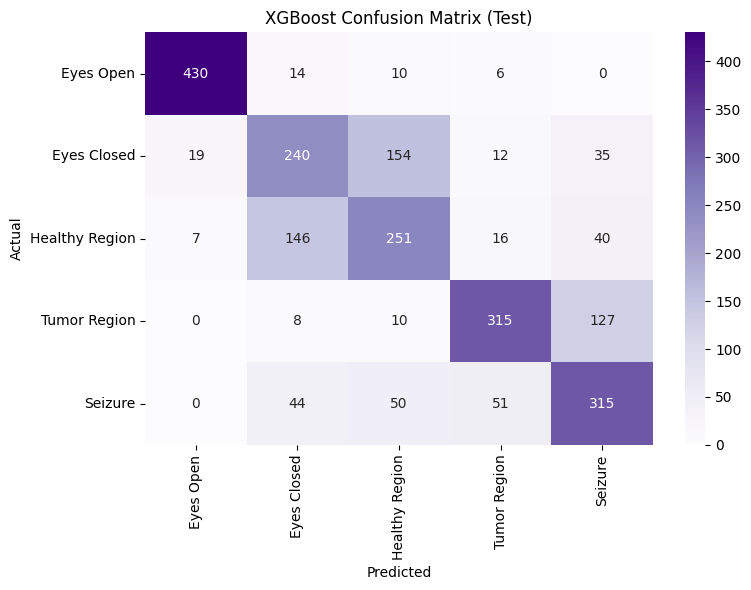

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define class labels (edit if needed)
class_labels = ['Eyes Open', 'Eyes Closed', 'Healthy Region', 'Tumor Region', 'Seizure']

# Compute confusion matrices
cm_xgb_val = confusion_matrix(y_val, y_pred_xgb_val)
cm_xgb_test = confusion_matrix(y_test, y_pred_xgb_test)

# Plot Validation Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb_val, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('XGBoost Confusion Matrix (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plot Test Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb_test, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('XGBoost Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [11]:
#   <--------------------------KNN--------------------------->


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train KNN
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

# Predict
y_pred_knn_val = knn.predict(X_val)
y_pred_knn_test = knn.predict(X_test)

# Evaluation
acc_knn_val = accuracy_score(y_val, y_pred_knn_val)
print(f"\nKNN Validation Accuracy: {acc_knn_val:.4f}")
acc_knn_test = accuracy_score(y_test, y_pred_knn_test)
print(f"KNN Test Accuracy: {acc_knn_test:.4f}")

print("\nConfusion Matrix for KNN (Validation):")
print(confusion_matrix(y_val, y_pred_knn_val))
print("\nClassification Report for KNN (Validation):")
print(classification_report(y_val, y_pred_knn_val))

print("\nConfusion Matrix for KNN (Test):")
print(confusion_matrix(y_test, y_pred_knn_test))
print("\nClassification Report for KNN (Test):")
print(classification_report(y_test, y_pred_knn_test))



KNN Validation Accuracy: 0.4878
KNN Test Accuracy: 0.4843

Confusion Matrix for KNN (Validation):
[[364  55  27  11   3]
 [  9 358  92   1   0]
 [  1 226 228   1   4]
 [  0 128 130 145  57]
 [  0 259 172   2  27]]

Classification Report for KNN (Validation):
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       460
           1       0.35      0.78      0.48       460
           2       0.35      0.50      0.41       460
           3       0.91      0.32      0.47       460
           4       0.30      0.06      0.10       460

    accuracy                           0.49      2300
   macro avg       0.58      0.49      0.47      2300
weighted avg       0.58      0.49      0.47      2300


Confusion Matrix for KNN (Test):
[[356  64  28  12   0]
 [ 13 349  96   1   1]
 [  0 231 228   0   1]
 [  0 148 122 150  40]
 [  0 244 177   8  31]]

Classification Report for KNN (Test):
              precision    recall  f1-score   support

       

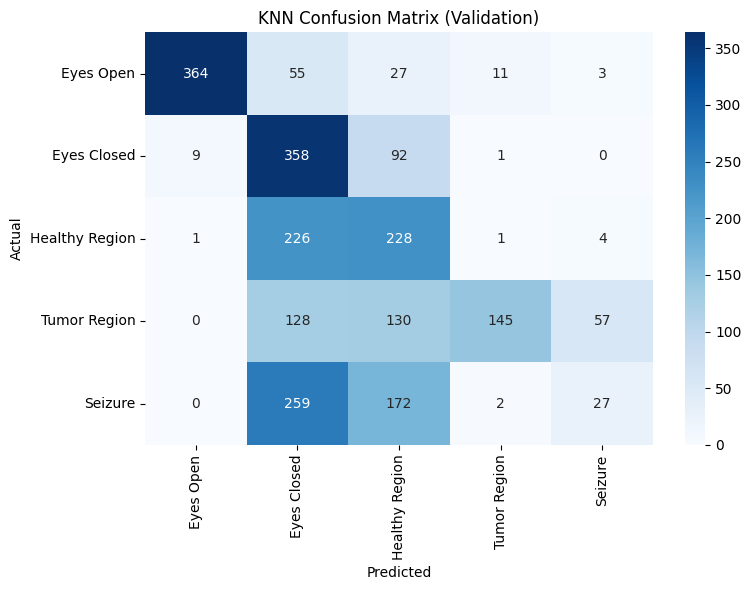

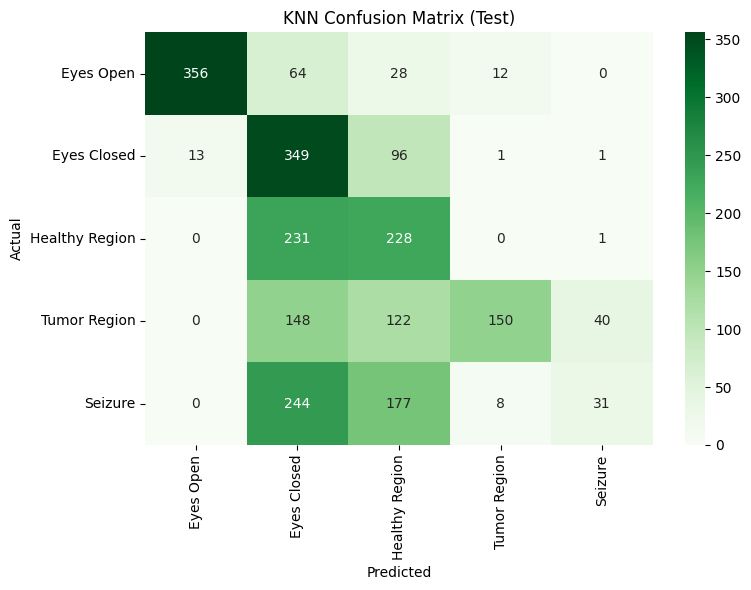

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define your class labels (edit if needed)
class_labels = ['Eyes Open', 'Eyes Closed', 'Healthy Region', 'Tumor Region', 'Seizure']

# Compute confusion matrices
cm_knn_val = confusion_matrix(y_val, y_pred_knn_val)
cm_knn_test = confusion_matrix(y_test, y_pred_knn_test)

# Plot Validation Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('KNN Confusion Matrix (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plot Test Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('KNN Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [13]:
#  <------------------------------------randomforest--------------------------------->
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf_val = rf.predict(X_val)
y_pred_rf_test = rf.predict(X_test)

# Evaluation
acc_rf_val = accuracy_score(y_val, y_pred_rf_val)
print(f"\nRandom Forest Validation Accuracy: {acc_rf_val:.4f}")
acc_rf_test = accuracy_score(y_test, y_pred_rf_test)
print(f"Random Forest Test Accuracy: {acc_rf_test:.4f}")

print("\nConfusion Matrix for Random Forest (Validation):")
print(confusion_matrix(y_val, y_pred_rf_val))
print("\nClassification Report for Random Forest (Validation):")
print(classification_report(y_val, y_pred_rf_val))

print("\nConfusion Matrix for Random Forest (Test):")
print(confusion_matrix(y_test, y_pred_rf_test))
print("\nClassification Report for Random Forest (Test):")
print(classification_report(y_test, y_pred_rf_test))



Random Forest Validation Accuracy: 0.6783
Random Forest Test Accuracy: 0.6691

Confusion Matrix for Random Forest (Validation):
[[440   4   6  10   0]
 [ 22 246 139  14  39]
 [ 11 128 249  30  42]
 [  0  13  12 337  98]
 [  0  35  59  78 288]]

Classification Report for Random Forest (Validation):
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       460
           1       0.58      0.53      0.56       460
           2       0.54      0.54      0.54       460
           3       0.72      0.73      0.73       460
           4       0.62      0.63      0.62       460

    accuracy                           0.68      2300
   macro avg       0.68      0.68      0.68      2300
weighted avg       0.68      0.68      0.68      2300


Confusion Matrix for Random Forest (Test):
[[437   8   2  13   0]
 [ 20 230 134  19  57]
 [ 10 130 243  22  55]
 [  1  12   7 333 107]
 [  0  34  52  78 296]]

Classification Report for Random Forest (Test):
  

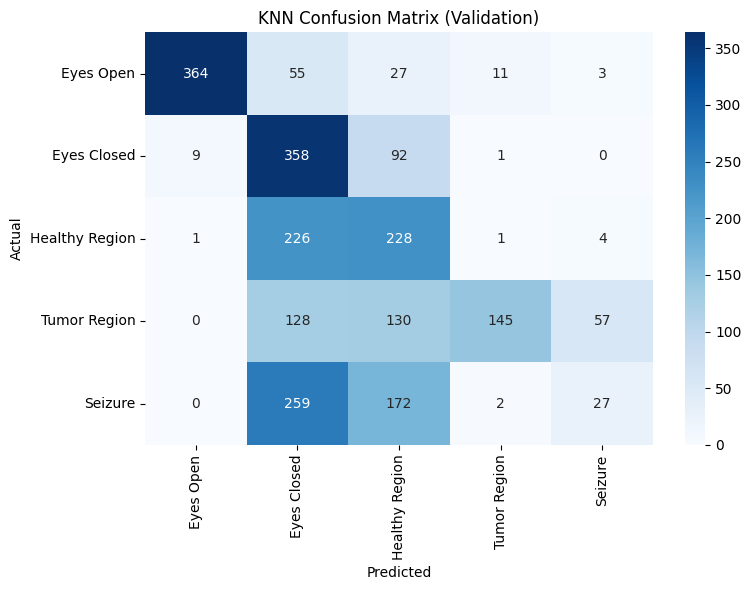

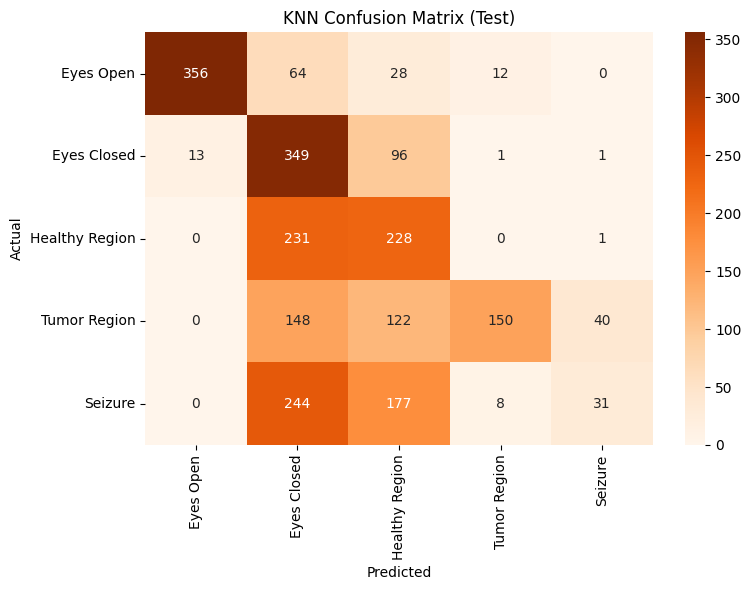

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define your class labels
class_labels = ['Eyes Open', 'Eyes Closed', 'Healthy Region', 'Tumor Region', 'Seizure']

# Compute confusion matrix for validation
cm_knn_val = confusion_matrix(y_val, y_pred_knn_val)

# Plot confusion matrix for validation
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('KNN Confusion Matrix (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Compute confusion matrix for test
cm_knn_test = confusion_matrix(y_test, y_pred_knn_test)

# Plot confusion matrix for test
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn_test, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('KNN Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


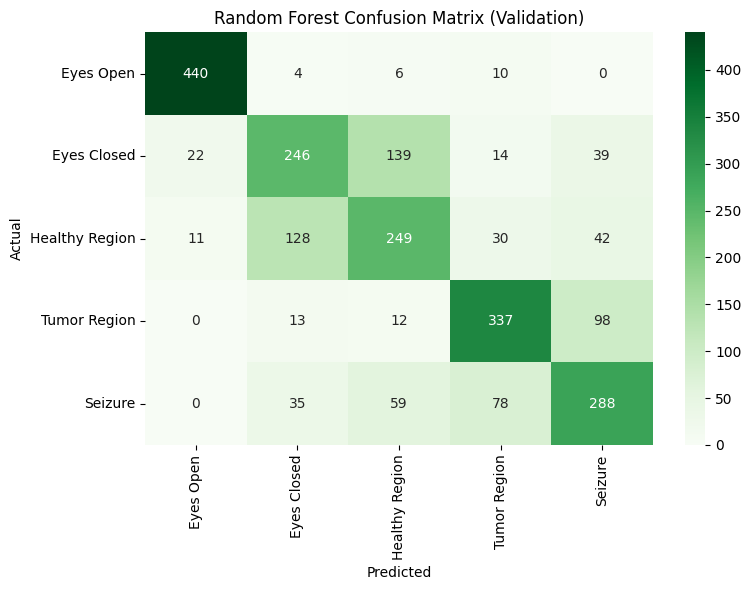

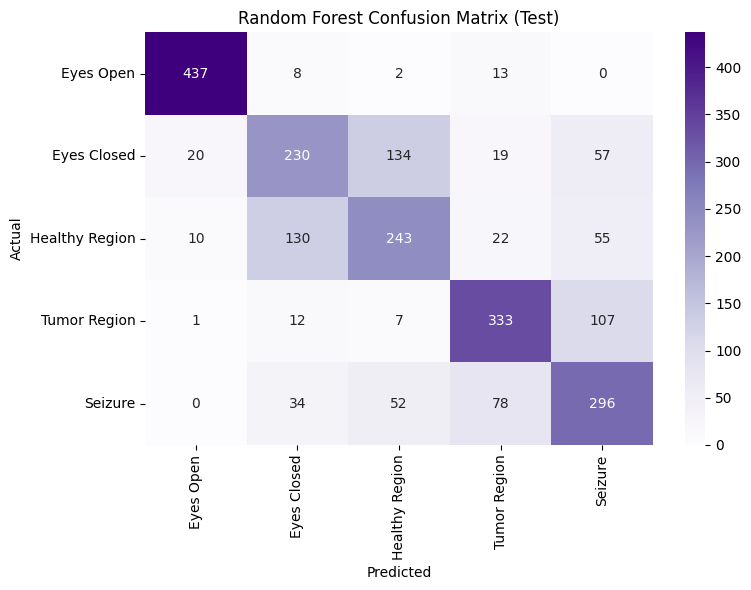

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define your class labels
class_labels = ['Eyes Open', 'Eyes Closed', 'Healthy Region', 'Tumor Region', 'Seizure']

# Compute confusion matrix for validation
cm_rf_val = confusion_matrix(y_val, y_pred_rf_val)

# Plot confusion matrix for validation
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_val, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Random Forest Confusion Matrix (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Compute confusion matrix for test
cm_rf_test = confusion_matrix(y_test, y_pred_rf_test)

# Plot confusion matrix for test
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_test, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Random Forest Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


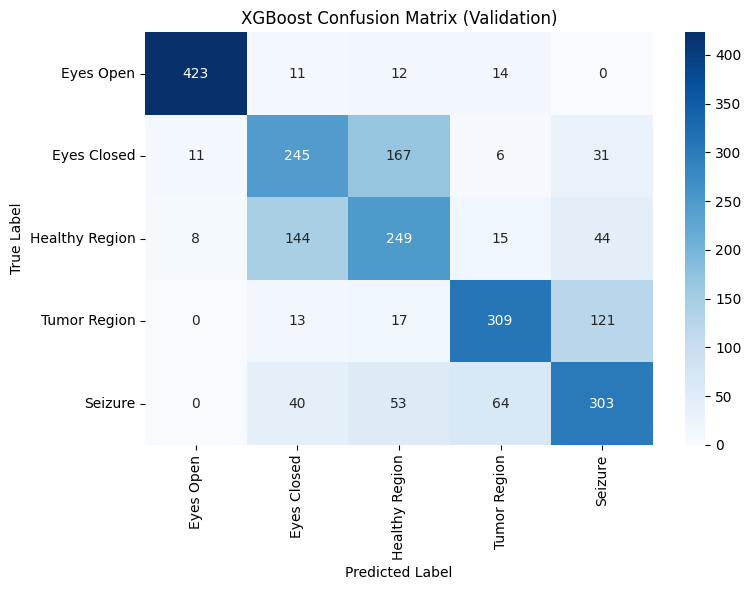

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Class labels (edit if needed)
class_labels = ['Eyes Open', 'Eyes Closed', 'Healthy Region', 'Tumor Region', 'Seizure']

# Generate confusion matrix
cm_val = confusion_matrix(y_val, y_pred_xgb_val)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix (Validation)')
plt.tight_layout()
plt.show()


In [17]:
X_train.shape

(6900, 178)

In [18]:
y_train.shape

(6900,)

In [19]:
X_val.shape

(2300, 178)

In [20]:
y_val.shape

(2300,)

In [21]:
# <--------------------------------------------------------DECISION TREE--------------------------------------------->
Dtree = DecisionTreeClassifier(random_state=42)
Dtree.fit(X_train, y_train)

# Predict
y_pred_val = Dtree.predict(X_val)
y_pred_test = Dtree.predict(X_test)

# Evaluate
print("Accuracy on Validation Set:", metrics.accuracy_score(y_val, y_pred_val))
print("Accuracy on Test Set:", metrics.accuracy_score(y_test, y_pred_test))
print("\nConfusion Matrix -> Validation:")
print(metrics.confusion_matrix(y_val, y_pred_val))
print("\nConfusion Matrix -> Test:")
print(metrics.confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:")
print(metrics.classification_report(y_val, y_pred_val))

Accuracy on Validation Set: 0.47608695652173916
Accuracy on Test Set: 0.4608695652173913

Confusion Matrix -> Validation:
[[360  38  30  23   9]
 [ 31 176 128  51  74]
 [ 20 131 174  51  84]
 [ 26  56  56 213 109]
 [  4  93  89 102 172]]

Confusion Matrix -> Test:
[[358  44  22  23  13]
 [ 28 166 118  42 106]
 [ 12 132 158  71  87]
 [ 20  66  56 198 120]
 [  4  96  96  84 180]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       460
           1       0.36      0.38      0.37       460
           2       0.36      0.38      0.37       460
           3       0.48      0.46      0.47       460
           4       0.38      0.37      0.38       460

    accuracy                           0.48      2300
   macro avg       0.48      0.48      0.48      2300
weighted avg       0.48      0.48      0.48      2300



In [22]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# One-hot encode the labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=5)
y_val = to_categorical(y_val, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

In [23]:

# Reshape for CNN: (samples, time_steps, channels)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 classes
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", round(accuracy * 100, 2), "%")

Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.4944 - loss: 1.3615 - val_accuracy: 0.2930 - val_loss: 2.9223
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step - accuracy: 0.6246 - loss: 0.8907 - val_accuracy: 0.4748 - val_loss: 1.8704
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.6236 - loss: 0.8480 - val_accuracy: 0.6630 - val_loss: 0.7848
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - accuracy: 0.6805 - loss: 0.7216 - val_accuracy: 0.6974 - val_loss: 0.6850
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.7100 - loss: 0.6376 - val_accuracy: 0.6891 - val_loss: 0.6647
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.7317 - loss: 0.5988 - val_accuracy: 0.7130 - val_loss: 0.6432
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.7445 - loss: 0.5577 - val_accuracy: 0.7104 - val_loss: 0.6665
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.7638 - loss: 0.5290 - 

In [24]:
X_val.shape

(2300, 178, 1)

In [25]:
X_val_2d = X_val.reshape(X_val.shape[0], X_val.shape[1])

In [26]:
'''# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the model
RNDM = RandomForestClassifier(n_estimators=100, random_state=42)

# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store scores
accuracy_scores = []
fold = 1

for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit model
    RNDM.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = RNDM.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    fold += 1

print("\nMean Accuracy across folds:", np.mean(accuracy_scores))'''
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming df is already loaded and preprocessed
# Separate features and target
X = df.drop(columns=['y'])

# Convert multiclass target to binary:
# 1 → seizure (label 1), 2-5 → non-seizure (label 0)
y = df['y'].apply(lambda val: 1 if val == 1 else 0)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the model
RNDM = RandomForestClassifier(n_estimators=100, random_state=42)

# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store scores
accuracy_scores = []
fold = 1

for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit model
    RNDM.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = RNDM.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    print(f"\nFold {fold} Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Non-Seizure', 'Seizure']))
    fold += 1

print("\nMean Accuracy across folds:", np.mean(accuracy_scores))


Fold 1 Accuracy: 0.9770
Confusion Matrix:
 [[1816   24]
 [  29  431]]
Classification Report:
               precision    recall  f1-score   support

 Non-Seizure       0.98      0.99      0.99      1840
     Seizure       0.95      0.94      0.94       460

    accuracy                           0.98      2300
   macro avg       0.97      0.96      0.96      2300
weighted avg       0.98      0.98      0.98      2300


Fold 2 Accuracy: 0.9748
Confusion Matrix:
 [[1816   24]
 [  34  426]]
Classification Report:
               precision    recall  f1-score   support

 Non-Seizure       0.98      0.99      0.98      1840
     Seizure       0.95      0.93      0.94       460

    accuracy                           0.97      2300
   macro avg       0.96      0.96      0.96      2300
weighted avg       0.97      0.97      0.97      2300


Fold 3 Accuracy: 0.9726
Confusion Matrix:
 [[1810   30]
 [  33  427]]
Classification Report:
               precision    recall  f1-score   support

 Non-S

In [ ]:
'''# Adjust target labels from [1–5] to [0–4]
y = df['y'] - 1
X = df.drop(columns=['y'])

# Step 2: Split into training+validation and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Split training set into train and validation sets (80% train, 20% val)
''''''X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval
)''''''

# Check the shapes
print(f"X_train shape: {X_train.shape}")
#print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

print(f"\ny class distribution in each split:")
print("Train:\n", y_train.value_counts())
#print("Validation:\n", y_val.value_counts())
print("Test:\n", y_test.value_counts())
'''

'# Adjust target labels from [1–5] to [0–4]\ny = df[\'y\'] - 1\nX = df.drop(columns=[\'y\'])\n\n# Step 2: Split into training+validation and test sets (80% train, 20% test)\nX_train, X_test, y_train, y_test = train_test_split(\n    X, y, test_size=0.2, random_state=42, stratify=y\n)\n\n# Step 3: Split training set into train and validation sets (80% train, 20% val)\nX_train, X_val, y_train, y_val = train_test_split(\n    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval\n)\n\n# Check the shapes\nprint(f"X_train shape: {X_train.shape}")\n#print(f"X_val shape: {X_val.shape}")\nprint(f"X_test shape: {X_test.shape}")\n\nprint(f"\ny class distribution in each split:")\nprint("Train:\n", y_train.value_counts())\n#print("Validation:\n", y_val.value_counts())\nprint("Test:\n", y_test.value_counts())\n'

In [ ]:
X_train_2d = X_train.reshape(X_train.shape[0], X_val.shape[1])
X_train_2d = X_train.reshape(X_train.shape[0], X_val.shape[1])

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming X and y are already defined and y is one-hot encoded (e.g. shape (6900, 5))
# Convert one-hot encoded y to integer labels
#y_labels = np.argmax(y, axis=1)  # shape (n_samples,)

'''# Split into train and test sets
X_train, X_test, y_train_labels, y_test_labels = train_test_split(
    X, y_labels, stratify=y_labels, test_size=0.2, random_state=42
)'''

# Reshape if X is 3D (like from CNN): (samples, 178, 1) → (samples, 178)
if len(X_train.shape) == 3:
    X_train_2d = X_train.reshape((X_train.shape[0], X_train.shape[1]))
    X_test_2d = X_test.reshape((X_test.shape[0], X_test.shape[1]))
else:
    X_train_2d = X_train
    X_test_2d = X_test

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

# Train SVM
svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

# Predictions
y_pred = svm.predict(X_test_scaled)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confidence scores (optional)
probs = svm.predict_proba(X_test_scaled)  # shape: (samples, num_classes)

Accuracy: 0.6186956521739131

Confusion Matrix:
[[443  11   3   3   0]
 [ 23 113 109   9 206]
 [  6  70 173   7 204]
 [  1  16  10 292 141]
 [  0  11  21  26 402]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       460
           1       0.51      0.25      0.33       460
           2       0.55      0.38      0.45       460
           3       0.87      0.63      0.73       460
           4       0.42      0.87      0.57       460

    accuracy                           0.62      2300
   macro avg       0.66      0.62      0.61      2300
weighted avg       0.66      0.62      0.61      2300



In [ ]:
# Your signal input
signal_input = {
    "X1": 135, "X2": 190, "X3": 229, "X4": 223, "X5": 192, "X6": 125, "X7": 55, "X8": -9, "X9": -33, "X10": -38,
    "X11": -10, "X12": 35, "X13": 64, "X14": 113, "X15": 152, "X16": 164, "X17": 127, "X18": 50, "X19": -47, "X20": -121,
    "X21": -138, "X22": -125, "X23": -101, "X24": -50, "X25": 11, "X26": 39, "X27": 24, "X28": 48, "X29": 64, "X30": 46,
    "X31": 13, "X32": -19, "X33": -61, "X34": -96, "X35": -130, "X36": -132, "X37": -116, "X38": -115, "X39": -71, "X40": -14,
    "X41": 25, "X42": 19, "X43": 6, "X44": 9, "X45": 21, "X46": 13, "X47": -37, "X48": -58, "X49": -33, "X50": 5,
    "X51": 47, "X52": 80, "X53": 101, "X54": 88, "X55": 73, "X56": 69, "X57": 41, "X58": -13, "X59": -31, "X60": -61,
    "X61": -80, "X62": -77, "X63": -66, "X64": -43, "X65": 5, "X66": 87, "X67": 129, "X68": 121, "X69": 88, "X70": 12,
    "X71": -76, "X72": -150, "X73": -207, "X74": -186, "X75": -165, "X76": -148, "X77": -103, "X78": -33, "X79": 40, "X80": 94,
    "X81": 75, "X82": 8, "X83": -81, "X84": -155, "X85": -227, "X86": -262, "X87": -233, "X88": -218, "X89": -187, "X90": -126,
    "X91": -65, "X92": -12, "X93": 27, "X94": 61, "X95": 49, "X96": 9, "X97": -46, "X98": -124, "X99": -210, "X100": -281,
    "X101": -265, "X102": -181, "X103": -89, "X104": -4, "X105": 53, "X106": 53, "X107": 38, "X108": 43, "X109": 31, "X110": 34,
    "X111": 9, "X112": -7, "X113": -34, "X114": -70, "X115": -84, "X116": -101, "X117": -70, "X118": -11, "X119": 42, "X120": 62,
    "X121": 66, "X122": 74, "X123": 64, "X124": 59, "X125": 56, "X126": 36, "X127": -11, "X128": -30, "X129": -43, "X130": -23,
    "X131": 8, "X132": 42, "X133": 77, "X134": 103, "X135": 135, "X136": 121, "X137": 79, "X138": 59, "X139": 43, "X140": 54,
    "X141": 90, "X142": 111, "X143": 107, "X144": 64, "X145": 32, "X146": 18, "X147": -25, "X148": -69, "X149": -65, "X150": -44,
    "X151": -33, "X152": -57, "X153": -88, "X154": -114, "X155": -130, "X156": -114, "X157": -83, "X158": -53, "X159": -79, "X160": -72,
    "X161": -85, "X162": -109, "X163": -98, "X164": -72, "X165": -65, "X166": -63, "X167": -11, "X168": 10, "X169": 8, "X170": -17,
    "X171": -15, "X172": -31, "X173": -77, "X174": -103, "X175": -127, "X176": -116, "X177": -83, "X178": -51
}
# 1. Convert the signal input dictionary to array
signal_array = np.array(list(signal_input.values()), dtype=np.float32).reshape(1, -1)

# 2. Apply standard scaling
custom_signal_scaled = scaler.transform(signal_array)  # shape: (1, 178)

# 3. Reshape for CNN input: (samples, time_steps, channels)
custom_signal_cnn = np.expand_dims(custom_signal_scaled, axis=-1)  # shape: (1, 178, 1)

# 4. Predict using CNN
cnn_probs = model.predict(custom_signal_cnn, verbose=0)

# 5. Extract predicted class and confidence
prediction_CNN = np.argmax(cnn_probs[0])  # Multiclass classification
confidence_score_CNN = cnn_probs[0][prediction_CNN]

print(f"CNN Predicted Class: {prediction_CNN}")
print(f" Confidence Score for predicted class: {confidence_score_CNN:.4f}")

CNN Predicted Class: 0
 Confidence Score for predicted class: 1.0000


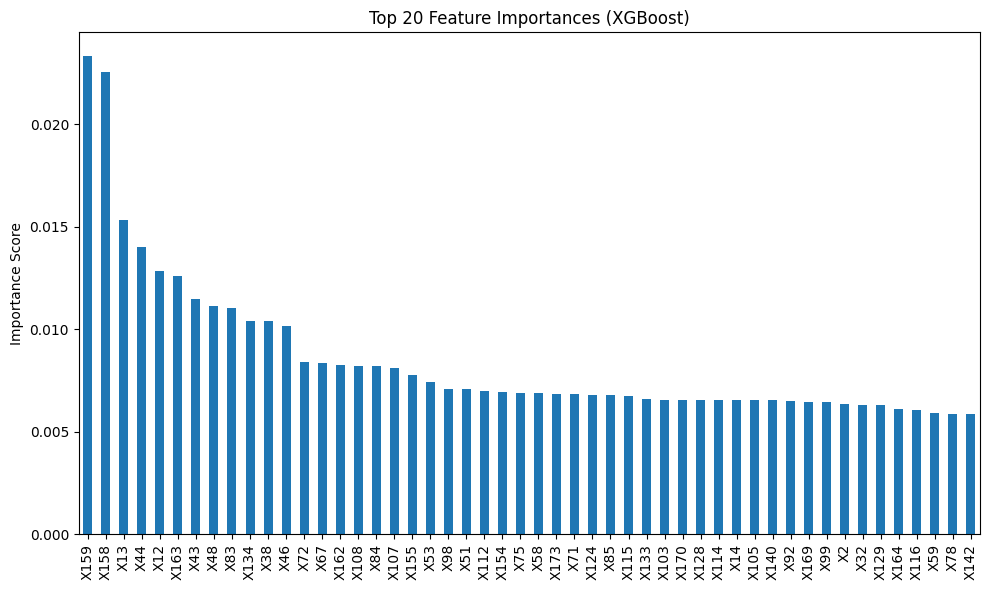

In [ ]:
importances = pd.Series(xgb.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)[:50]  # Top 20

plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title("Top 20 Feature Importances (XGBoost)")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='softmax')  # For binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("best_nn_model.h5", monitor="val_loss", save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr, model_checkpoint],
    verbose=1
)


Epoch 1/50
277/288 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1993 - loss: 0.4765
Epoch 1: val_loss improved from inf to 0.14898, saving model to best_nn_model.h5


288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.1994 - loss: 0.4707 - val_accuracy: 0.2000 - val_loss: 0.1490 - learning_rate: 0.0010
Epoch 2/50
266/288 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2043 - loss: 0.1446
Epoch 2: val_loss improved from 0.14898 to 0.11403, saving model to best_nn_model.h5


288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2040 - loss: 0.1443 - val_accuracy: 0.2000 - val_loss: 0.1140 - learning_rate: 0.0010
Epoch 3/50
271/288 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1993 - loss: 0.1011
Epoch 3: val_loss improved from 0.11403 to 0.09552, saving model to best_nn_model.h5


288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1994 - loss: 0.1013 - val_accuracy: 0.2000 - val_loss: 0.0955 - learning_rate: 0.0010
Epoch 4/50
275/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1934 - loss: 0.0859
Epoch 4: val_loss improved from 0.09552 to 0.08172, saving model to best_nn_model.h5


288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1937 - loss: 0.0858 - val_accuracy: 0.2000 - val_loss: 0.0817 - learning_rate: 0.0010
Epoch 5/50
272/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1971 - loss: 0.0804
Epoch 5: val_loss did not improve from 0.08172
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1973 - loss: 0.0810 - val_accuracy: 0.2000 - val_loss: 0.0960 - learning_rate: 0.0010
Epoch 6/50
287/288 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2013 - loss: 0.0780
Epoch 6: val_loss improved from 0.08172 to 0.07687, saving model to best_nn_model.h5


288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2013 - loss: 0.0780 - val_accuracy: 0.2000 - val_loss: 0.0769 - learning_rate: 0.0010
Epoch 7/50
278/288 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1984 - loss: 0.0620
Epoch 7: val_loss did not improve from 0.07687
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1985 - loss: 0.0623 - val_accuracy: 0.2000 - val_loss: 0.0799 - learning_rate: 0.0010
Epoch 8/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1976 - loss: 0.0636
Epoch 8: val_loss did not improve from 0.07687
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1976 - loss: 0.0636 - val_accuracy: 0.2000 - val_loss: 0.0775 - learning_rate: 0.0010
Epoch 9/50
279/288 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1975 - loss: 0.0623
Epoch 9: val_loss improved from 0.07687 to 0.07308, saving model to best_nn_model.h5


288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1976 - loss: 0.0623 - val_accuracy: 0.2000 - val_loss: 0.0731 - learning_rate: 0.0010
Epoch 10/50
275/288 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1975 - loss: 0.0607
Epoch 10: val_loss did not improve from 0.07308
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1976 - loss: 0.0608 - val_accuracy: 0.2000 - val_loss: 0.0763 - learning_rate: 0.0010
Epoch 11/50
283/288 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1867 - loss: 0.0456
Epoch 11: val_loss improved from 0.07308 to 0.06775, saving model to best_nn_model.h5


288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1870 - loss: 0.0458 - val_accuracy: 0.2000 - val_loss: 0.0677 - learning_rate: 0.0010
Epoch 12/50
285/288 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2015 - loss: 0.0481
Epoch 12: val_loss did not improve from 0.06775
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2015 - loss: 0.0482 - val_accuracy: 0.2000 - val_loss: 0.0726 - learning_rate: 0.0010
Epoch 13/50
281/288 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1946 - loss: 0.0445
Epoch 13: val_loss did not improve from 0.06775
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1948 - loss: 0.0447 - val_accuracy: 0.2000 - val_loss: 0.0710 - learning_rate: 0.0010
Epoch 14/50
269/288 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2037 - loss: 0.0548
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 14: val_loss did not improve from 0.06775
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2034 - loss: 0.0548 - val_accuracy: 0.2

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1989 - loss: 0.0354 - val_accuracy: 0.2000 - val_loss: 0.0672 - learning_rate: 3.0000e-04
Epoch 17/50
276/288 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1964 - loss: 0.0331
Epoch 17: val_loss improved from 0.06717 to 0.06679, saving model to best_nn_model.h5


288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1965 - loss: 0.0331 - val_accuracy: 0.2000 - val_loss: 0.0668 - learning_rate: 3.0000e-04
Epoch 18/50
286/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1965 - loss: 0.0308
Epoch 18: val_loss improved from 0.06679 to 0.06595, saving model to best_nn_model.h5


288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1965 - loss: 0.0308 - val_accuracy: 0.2000 - val_loss: 0.0660 - learning_rate: 3.0000e-04
Epoch 19/50
282/288 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1859 - loss: 0.0293
Epoch 19: val_loss improved from 0.06595 to 0.06253, saving model to best_nn_model.h5


288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1862 - loss: 0.0293 - val_accuracy: 0.2000 - val_loss: 0.0625 - learning_rate: 3.0000e-04
Epoch 20/50
283/288 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1981 - loss: 0.0311
Epoch 20: val_loss did not improve from 0.06253
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1981 - loss: 0.0312 - val_accuracy: 0.2000 - val_loss: 0.0690 - learning_rate: 3.0000e-04
Epoch 21/50
283/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1978 - loss: 0.0277
Epoch 21: val_loss did not improve from 0.06253
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1978 - loss: 0.0278 - val_accuracy: 0.2000 - val_loss: 0.0697 - learning_rate: 3.0000e-04
Epoch 22/50
287/288 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2021 - loss: 0.0302
Epoch 22: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 22: val_loss did not improve from 0.06253
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2021 - loss: 0.0302 - val_a

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Dictionary of models and their predicted probabilities (for class 1)
# Replace or add more models as per your use
model_predictions = {
    'Random Forest': rf.predict_proba(X_val)[:, 1],
    'XGBoost': xgb.predict_proba(X_val)[:, 1],
    'Decision Tree': Dtree.predict_proba(X_val)[:, 1],
    'KNN': knn.predict_proba(X_val)[:, 1],
    "CNN" : model.predict(X_val).ravel()
    # 'Neural Net': model.predict(x_val).ravel(),  # if using Keras
}

# Plotting
plt.figure(figsize=(10, 7))

for name, probs in model_predictions.items():
    fpr, tpr, _ = roc_curve(y_val, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Diagonal line (no-skill classifier)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')

plt.title('ROC Curve Comparison of Models', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: Found array with dim 3. RandomForestClassifier expected <= 2.